In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
import time

sys.path.append(os.environ['REPO_DIR'] + '/utilities')
from utilities2015 import *
from metadata import *
from data_manager import *
from learning_utilities import *

%matplotlib inline

Setting environment for Precision WorkStation


No vtk
/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Based on contour annotation

In [2]:
windowing_settings

{1: {'patch_size': 224, 'spacing': 56},
 2: {'comment': 'larger margin', 'patch_size': 224, 'spacing': 56},
 3: {'comment': 'smaller spacing', 'patch_size': 224, 'spacing': 32},
 4: {'comment': 'smaller spacing', 'patch_size': 224, 'spacing': 128},
 5: {'comment': 'smaller spacing', 'patch_size': 224, 'spacing': 64},
 6: {'comment': 'twice as large patch', 'patch_size': 448, 'spacing': 64},
 7: {'comment': 'specify size/spacing in terms of microns rather than pixels',
  'patch_size_um': 103.04,
  'spacing_um': 30},
 8: {'comment': 'larger patch', 'patch_size_um': 206.08, 'spacing_um': 30},
 9: {'comment': 'larger patch', 'patch_size_um': 412.16, 'spacing_um': 30},
 10: {'comment': 'larger patch', 'patch_size_um': 824.32, 'spacing_um': 30}}

In [ ]:
win_id = 7
for stack in ['MD585', 'MD594', 'MD589']:
    grid_index_class_lookup, latest_timestamp = generate_annotation_to_grid_indices_lookup(stack, win_id=win_id, by_human=True, 
                                                                         suffix='contours', timestamp='latest',
                                                                         surround_margins=[200, 500],
                                                                        return_timestamp=True)
    
    grid_index_class_lookup_fp = \
    DataManager.get_annotation_to_grid_indices_lookup_filepath(stack=stack, win_id=win_id, 
                                                               by_human=True, timestamp=latest_timestamp)
    print grid_index_class_lookup_fp

    save_hdf_v2(grid_index_class_lookup, grid_index_class_lookup_fp)
    upload_to_s3(grid_index_class_lookup_fp)

In [ ]:
# win_id = 3
# windowing_properties = windowing_settings[win_id]
# patch_size = windowing_properties['patch_size']
# spacing = windowing_properties['spacing']
# w, h = metadata_cache['image_shape'][stack]
# half_size = patch_size/2
# grid_spec = (patch_size, spacing, w, h)

# Based on aligned atlas

In [ ]:
positive_level = {}
for name_u in all_known_structures:
    if name_u == '4N':
        positive_level[name_u] = 0.6
    elif name_u == '10N':
        positive_level[name_u] = 0.7
    else:
        positive_level[name_u] = 0.8
        
# positive_level = 0.8

In [ ]:
from learning_utilities import *

In [ ]:
# stack = 'ChatCryoJane201710'
for stack in [
 'MD652',
 'MD653',
 'MD657',
'MD658']:
    win_id = 5
    detector_id = 13
    grid_index_class_lookup = generate_annotation_to_grid_indices_lookup(stack=stack, win_id=win_id, by_human=False, 
                                                                                    detector_id_f=detector_id,
                                                                        surround_margins=[200],
                                                                        positive_level=0.8, negative_level=0.1)
    grid_index_class_lookup_fp = \
DataManager.get_annotation_to_grid_indices_lookup_filepath(stack=stack, win_id=win_id, by_human=False, 
                                                                     stack_m='atlasV5', 
                                                                                detector_id_f=detector_id,
                                                          timestamp='now')
    save_hdf_v2(grid_index_class_lookup, grid_index_class_lookup_fp)
    upload_to_s3(grid_index_class_lookup_fp)

In [ ]:
# stack = 'ChatCryoJane201710'
for stack in [
 'MD661',
 'MD662']:
    win_id = 7
    detector_id = 1
    grid_index_class_lookup = generate_annotation_to_grid_indices_lookup(stack=stack, win_id=win_id, by_human=False, 
                                                                                    detector_id_f=detector_id,
                                                                        surround_margins=[200],
                                                                        positive_level=positive_level, 
                                                                         negative_level=0.1)
    grid_index_class_lookup_fp = \
DataManager.get_annotation_to_grid_indices_lookup_filepath(stack=stack, win_id=win_id, by_human=False, 
                                                                     stack_m='atlasV5', 
                                                                                detector_id_f=detector_id,
                                                          timestamp='now')
    save_hdf_v2(grid_index_class_lookup, grid_index_class_lookup_fp)
    upload_to_s3(grid_index_class_lookup_fp)

# Use human-corrected structure annotation file

In [2]:
def generate_annotation_to_grid_indices_lookup_v2(stack, by_human, win_id,
                                               stack_m='atlasV5',
                                               detector_id_m=None,
                                                detector_id_f=None,
                                                warp_setting=17, trial_idx=None,
                                              surround_margins_um=None, suffix='contours', 
                                                  timestamp='latest', prep_id='alignedBrainstemCrop',
                                                positive_level=0.8, negative_level=0.2,
                                              return_timestamp=False,
                                                  sections=None,
                                              structures=None):
    
    structures_df = DataManager.load_annotation_v4(stack=stack, by_human=by_human, 
                                                   suffix=suffix, 
                                                   timestamp=timestamp)

    warped_volumes, warped_volumes_resolution = \
    convert_structure_annotation_to_volume_origin_dict_v2(structures_df=structures_df, 
                                                          out_resolution='10.0um', stack=stack)
    
    sample_every = 5
    
    structure_contours_wrt_alignedBrainstemCrop_rawResol_pos_level = \
    get_structure_contours_from_structure_volumes_v2(warped_volumes, stack=stack,
                                                     sections=metadata_cache['valid_sections'][stack] if sections is None else sections,
                                                     resolution=warped_volumes_resolution,
                                                     level=positive_level,
                                                     sample_every=sample_every, 
                                                     use_unsided_name_as_key=True)

    structure_contours_wrt_alignedBrainstemCrop_rawResol_neg_level = \
    get_structure_contours_from_structure_volumes_v2(warped_volumes, stack=stack,
                                                     sections=metadata_cache['valid_sections'][stack] if sections is None else sections,
                                                     resolution=warped_volumes_resolution,
                                                     level=negative_level,
                                                     sample_every=sample_every, 
                                                      use_unsided_name_as_key=True)
    
    grid_spec = win_id_to_gridspec(win_id=win_id, stack=stack)
    
    patch_indices_allSections_allStructures = {}

    sections = \
    sorted(list(set(structure_contours_wrt_alignedBrainstemCrop_rawResol_pos_level.keys()) | \
    set(structure_contours_wrt_alignedBrainstemCrop_rawResol_neg_level.keys())))

    for sec in sections:

        sys.stderr.write('Computing grid indices lookup for section %d...\n' % sec)

        mask_tb = DataManager.load_thumbnail_mask_v3(stack=stack, section=sec, prep_id=prep_id)

        patch_indices_thisSection_allStructures = {}

        if sec in structure_contours_wrt_alignedBrainstemCrop_rawResol_pos_level:

            patch_indices_thisSection_allStructures.update(
            locate_patches_v2(grid_spec=grid_spec, 
                              mask_tb=mask_tb,
                              polygons=structure_contours_wrt_alignedBrainstemCrop_rawResol_pos_level[sec].items(), \
                              surround_margins=surround_margins_um, 
                              categories=['positive']))

        if sec in structure_contours_wrt_alignedBrainstemCrop_rawResol_neg_level:

            patch_indices_thisSection_allStructures.update(
            locate_patches_v2(grid_spec=grid_spec, 
                              mask_tb=mask_tb,
                              polygons=structure_contours_wrt_alignedBrainstemCrop_rawResol_neg_level[sec].items(), \
                              surround_margins=surround_margins_um, 
                              categories=['surround']))

        if len(patch_indices_thisSection_allStructures) > 0:
            patch_indices_allSections_allStructures[sec] = patch_indices_thisSection_allStructures
            
    if return_timestamp:
        return DataFrame(patch_indices_allSections_allStructures).T, timestamp
    else:
        return DataFrame(patch_indices_allSections_allStructures).T

In [3]:
def get_structure_contours_from_structure_volumes_v2(volumes, stack, sections, 
                                                     resolution, level, sample_every=1,
                                                    use_unsided_name_as_key=False):
    """
    Re-section atlas volumes and obtain structure contours on each section.
    Resolution of output contours are in volume resolution.

    Args:
        volumes (dict of (3D array, 3-tuple)): {structure: (volume, origin_wrt_wholebrain)}. volume is a 3d array of probability values.
        sections (list of int):
        resolution (int): resolution of input volumes.
        level (float or dict): the cut-off probability at which surfaces are generated from probabilistic volumes. Default is 0.5.
        sample_every (int): how sparse to sample contour vertices.

    Returns:
        Dict {section: {name_s: contour vertices}}.
    """

    from collections import defaultdict
    
    structure_contours_wrt_alignedBrainstemCrop_rawResol = defaultdict(dict)

    converter = CoordinatesConverter(stack=stack, section_list=metadata_cache['sections_to_filenames'][stack].keys())

    converter.register_new_resolution('structure_volume', resol_um=convert_resolution_string_to_um(resolution=resolution, stack=stack))
    converter.register_new_resolution('image', resol_um=convert_resolution_string_to_um(resolution='raw', stack=stack))
    
    for name_s, (structure_volume_volResol, origin_wrt_wholebrain_volResol) in volumes.iteritems():

        converter.derive_three_view_frames(name_s, 
        origin_wrt_wholebrain_um=convert_resolution_string_to_um(resolution=resolution, stack=stack) * origin_wrt_wholebrain_volResol,
        zdim_um=convert_resolution_string_to_um(resolution=resolution, stack=stack) * structure_volume_volResol.shape[2])

        positions_of_all_sections_wrt_structureVolume = converter.convert_frame_and_resolution(
        p=np.array(sections)[:,None],
        in_wrt=('wholebrain', 'sagittal'), in_resolution='section',
        out_wrt=(name_s, 'sagittal'), out_resolution='structure_volume')[..., 2].flatten()
            
        structure_ddim = structure_volume_volResol.shape[2]
        
        valid_mask = (positions_of_all_sections_wrt_structureVolume >= 0) & (positions_of_all_sections_wrt_structureVolume < structure_ddim)
        if np.count_nonzero(valid_mask) == 0:
#             sys.stderr.write("%s, valid_mask is empty.\n" % name_s)
            continue

        positions_of_all_sections_wrt_structureVolume = positions_of_all_sections_wrt_structureVolume[valid_mask]
        positions_of_all_sections_wrt_structureVolume = np.round(positions_of_all_sections_wrt_structureVolume).astype(np.int)
        
        if isinstance(level, dict):
            level_this_structure = level[name_s]
        elif isinstance(level, float):
            level_this_structure = level
        else:
            raise

        contour_2d_wrt_structureVolume_sectionPositions_volResol = \
        find_contour_points_3d(structure_volume_volResol >= level_this_structure,
                                along_direction='sagittal',
                                sample_every=sample_every,
                                positions=positions_of_all_sections_wrt_structureVolume)
                        
        for d_wrt_structureVolume, cnt_uv_wrt_structureVolume in contour_2d_wrt_structureVolume_sectionPositions_volResol.iteritems():
            
            contour_3d_wrt_structureVolume_volResol = np.column_stack([cnt_uv_wrt_structureVolume, np.ones((len(cnt_uv_wrt_structureVolume),)) * d_wrt_structureVolume])
            
#             contour_3d_wrt_wholebrain_uv_rawResol_section = converter.convert_frame_and_resolution(
#                 p=contour_3d_wrt_structureVolume_volResol,
#                 in_wrt=(name_s, 'sagittal'), in_resolution='structure_volume',
#                 out_wrt=('wholebrain', 'sagittal'), out_resolution='image_image_section')

            contour_3d_wrt_alignedBrainstemCrop_uv_rawResol_section = converter.convert_frame_and_resolution(
                p=contour_3d_wrt_structureVolume_volResol,
                in_wrt=(name_s, 'sagittal'), in_resolution='structure_volume',
                out_wrt=('wholebrainXYcropped', 'sagittal'), out_resolution='image_image_section')
            
            assert len(np.unique(contour_3d_wrt_alignedBrainstemCrop_uv_rawResol_section[:,2])) == 1
            sec = int(contour_3d_wrt_alignedBrainstemCrop_uv_rawResol_section[0,2])
        
            if use_unsided_name_as_key:
                name = convert_to_unsided_label(name_s)
            else:
                name = name_s
            structure_contours_wrt_alignedBrainstemCrop_rawResol[sec][name] = contour_3d_wrt_alignedBrainstemCrop_uv_rawResol_section[..., :2]

    return structure_contours_wrt_alignedBrainstemCrop_rawResol

In [4]:
positive_level = {}
for name_s in all_known_structures_sided:
    name_u = convert_to_unsided_label(name_s)
    if name_u == '4N':
        positive_level[name_s] = 0.6
    elif name_u == '10N':
        positive_level[name_s] = 0.7
    else:
        positive_level[name_s] = 0.8

# positive_level = 0.8

negative_level = .1

In [5]:
win_id = 7

In [6]:
for stack in ['CHATM3']:
    
#     timestamp = '04262018105643' # CHATM2
    timestamp = '04272018015834' # CHATM3
    
    grid_index_class_lookup = \
    generate_annotation_to_grid_indices_lookup_v2(stack=stack, win_id=win_id, 
                                                by_human=True, 
                                            surround_margins_um=[200, 500],
                                            positive_level=positive_level, 
                                             negative_level=negative_level,
                                            suffix='structures',
                                               timestamp=timestamp,
                                               sections=metadata_cache['valid_sections'][stack])
    grid_index_class_lookup_fp = \
DataManager.get_annotation_to_grid_indices_lookup_filepath(stack=stack, win_id=win_id, by_human=True, 
                                                           timestamp=timestamp,
                                                          suffix='structures')
    save_data(grid_index_class_lookup, grid_index_class_lookup_fp, upload_s3=False)

2 contours of reconstructed volume is found at position 100 ([72, 17]). Use the longest one.
2 contours of reconstructed volume is found at position 105 ([25, 1]). Use the longest one.
2 contours of reconstructed volume is found at position 18 ([2, 1]). Use the longest one.
contour has less than three vertices. Ignore.
contour has less than three vertices. Ignore.
2 contours of reconstructed volume is found at position 93 ([49, 2]). Use the longest one.
2 contours of reconstructed volume is found at position 32 ([55, 1]). Use the longest one.
2 contours of reconstructed volume is found at position 42 ([67, 1]). Use the longest one.
2 contours of reconstructed volume is found at position 48 ([74, 1]). Use the longest one.
2 contours of reconstructed volume is found at position 74 ([78, 1]). Use the longest one.
2 contours of reconstructed volume is found at position 130 ([31, 1]). Use the longest one.
2 contours of reconstructed volume is found at position 46 ([55, 1]). Use the longest 

Computing grid indices lookup for section 100...
Computing grid indices lookup for section 101...
Computing grid indices lookup for section 102...
Computing grid indices lookup for section 103...
Computing grid indices lookup for section 104...
Computing grid indices lookup for section 105...
Computing grid indices lookup for section 107...
Computing grid indices lookup for section 108...
Multiple polygons for VCA (margin 500 um): [57, 4, 4]. Use the longest.
Computing grid indices lookup for section 109...
Computing grid indices lookup for section 110...
Computing grid indices lookup for section 111...
Computing grid indices lookup for section 112...
Computing grid indices lookup for section 113...
Computing grid indices lookup for section 114...
Computing grid indices lookup for section 115...
Computing grid indices lookup for section 116...
Computing grid indices lookup for section 117...
Computing grid indices lookup for section 118...
Computing grid indices lookup for section 119.

Computing grid indices lookup for section 271...
Computing grid indices lookup for section 273...
Computing grid indices lookup for section 275...
Computing grid indices lookup for section 277...
Multiple polygons for SNR (margin 500 um): [96, 4]. Use the longest.
Computing grid indices lookup for section 279...
Computing grid indices lookup for section 281...
Computing grid indices lookup for section 283...
Computing grid indices lookup for section 285...
Computing grid indices lookup for section 287...
Computing grid indices lookup for section 289...
Computing grid indices lookup for section 291...
Computing grid indices lookup for section 293...
Computing grid indices lookup for section 295...
Computing grid indices lookup for section 297...
Computing grid indices lookup for section 299...
Multiple polygons for SC (margin 500 um): [142, 4, 4]. Use the longest.
Computing grid indices lookup for section 301...
Computing grid indices lookup for section 303...
Computing grid indices loo

# Examine

In [12]:
stack = 'CHATM3'
win_id = 7
sec = 128

In [13]:
timestamp = '04272018015834'

In [14]:
grid_index_class_lookup = \
DataManager.load_annotation_to_grid_indices_lookup(stack=stack, win_id=win_id, by_human=True, 
                                                   timestamp=timestamp, suffix='structures')

In [15]:
# img = DataManager.load_image_v2(stack=stack, section=sec, prep_id=2, version='gray')
img = DataManager.load_image_v2(stack=stack, section=sec, prep_id=2, version='NtbNormalizedAdaptiveInvertedGamma')

Not using image_cache.


/data/CSHL_data_processed/CHATM3/CHATM3_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/CHATM3_slide44_2018_02_19-S2_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif


In [16]:
all_locs = grid_parameters_to_sample_locations(win_id=win_id, stack=stack)

In [17]:
viz = gray2rgb(img)

for label, grids in grid_index_class_lookup.loc[sec].dropna().iteritems():
    if parse_label(label)[2] == '500um':
        continue
    for x, y in all_locs[grid_index_class_lookup[label][sec]]:        
        cv2.circle(viz, (x, y), 10, name_unsided_to_color[convert_to_original_name(label)], 20)

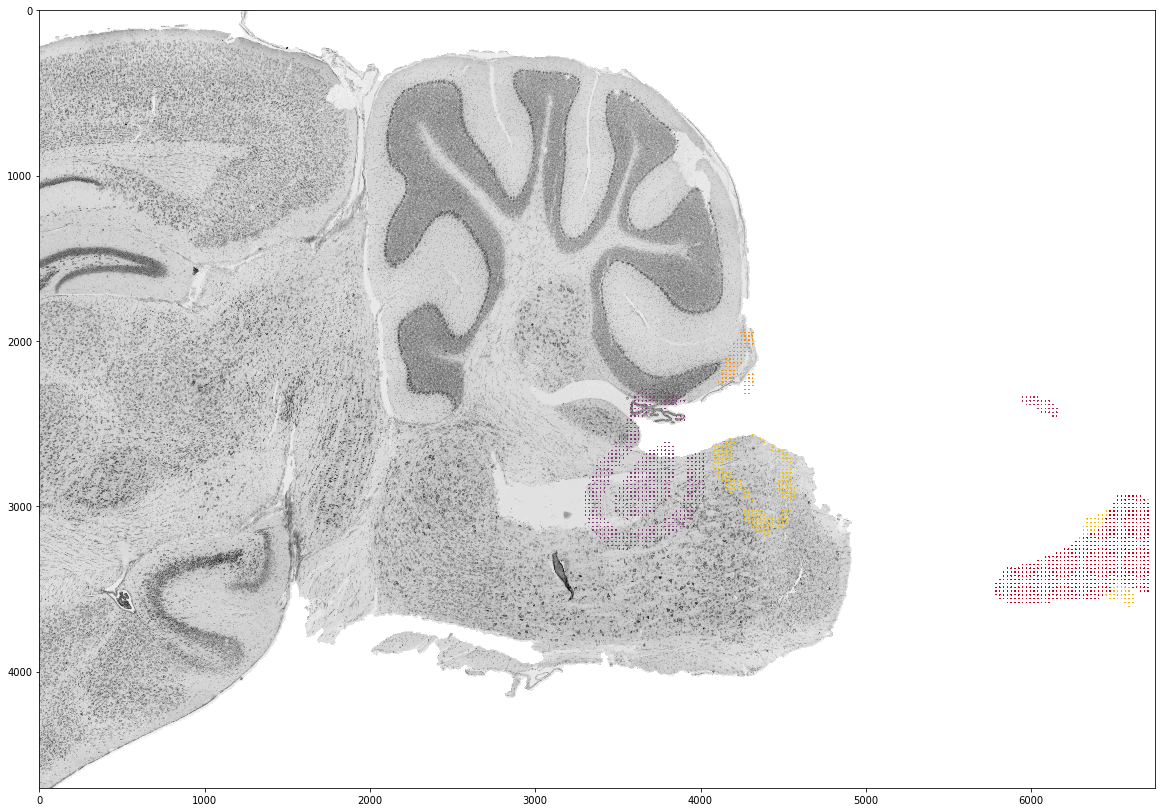

In [18]:
plt.figure(figsize=(20,20));
plt.imshow(viz[::4, ::4]);

In [32]:
viz = gray2rgb(img)

# for s in ['VCA', 'VCP']:
for s in ['7N', convert_to_surround_name(name='7N', margin='200um', suffix='noclass')]:
    all_locs = grid_parameters_to_sample_locations(win_id=win_id, stack=stack)
    if not sec in grid_index_class_lookup[s].dropna():
        sys.stderr.write("No %s patches on section %d.\n" % (s, sec))
        continue
        
    for x, y in all_locs[grid_index_class_lookup[s][sec]]:
        cv2.circle(viz, (x, y), 10, (255,0,0), 5)

In [34]:
display_image(viz[::4, ::4])

/home/yuncong/Brain/learning/tmp.jpg

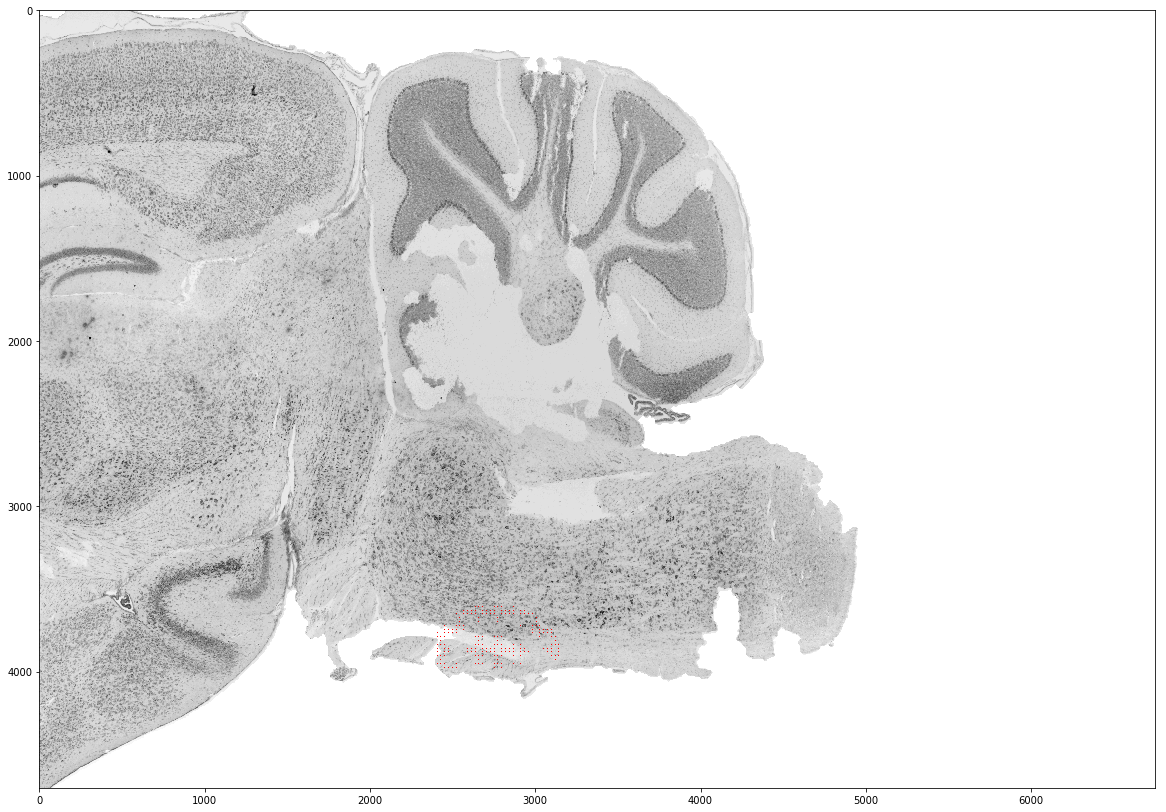

In [33]:
plt.figure(figsize=(20,20));
plt.imshow(viz[::4, ::4]);

# Save and Upload

In [ ]:
grid_index_class_lookup_fp = \
DataManager.get_annotation_to_grid_indices_lookup_filepath(stack=stack, win_id=win_id, 
                                                           by_human=True, timestamp=latest_timestamp)
print grid_index_class_lookup_fp

In [ ]:
grid_index_class_lookup_fp = \
DataManager.get_annotation_to_grid_indices_lookup_filepath(stack=stack, win_id=win_id, by_human=False, 
                                                                     stack_m='atlasV5', 
                                                                                detector_id_f=detector_id,
                                                          timestamp='now')

In [ ]:
save_hdf_v2(grid_index_class_lookup, grid_index_class_lookup_fp)
upload_to_s3(grid_index_class_lookup_fp)

In [ ]:
stack = 'MD595'

In [ ]:
grid_index_class_lookup = \
DataManager.load_annotation_to_grid_indices_lookup(stack=stack, win_id=win_id, by_human=False, 
                                                                     stack_m=atlas_name, 
                                                                                detector_id_f=detector_id,
                                                           prep_id_f=2,
                                                                                warp_setting=warp_setting,
                                                          timestamp='latest')

In [ ]:
grid_index_class_lookup = DataManager.load_annotation_to_grid_indices_lookup(stack='MD589', win_id=5, 
                                                                             by_human=True,
                                                                            timestamp='latest')

In [ ]:
grid_index_class_lookup.loc[108]['VCA']

In [ ]:
# for stack in all_annotated_stacks:
    
#     sys.stderr.write('%s\n' % stack)
    
#     label_gridIndices = locate_annotated_patches_v2(stack=stack)
    
#     annotation_grid_indices_fn = os.path.join(ANNOTATION_ROOTDIR, stack, '%(stack)s_annotation_grid_indices.h5' % dict(stack=stack))
#     label_gridIndices.to_hdf(annotation_grid_indices_fn, 'grid_indices')

In [ ]:
# label_gridIndices = read_hdf(annotation_grid_indices_fn, 'grid_indices')